In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 14936, done.
remote: Total 14936 (delta 0), reused 0 (delta 0), pack-reused 14936
Receiving objects: 100% (14936/14936), 13.98 MiB | 31.75 MiB/s, done.
Resolving deltas: 100% (10267/10267), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [2]:
from google.colab import drive                                    #Mounting Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.1 MB/s eta 0:00:00
Setup complete. Using torch 1.13.0+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [4]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 9.2 MB/s eta 0:00:00
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="VHUNZVum5LOXuHQx6iIJ")                             #import dataset from roboflow
project = rf.workspace("maharaja-agrasen-institute-of-technology-djf0c").project("pipes-vg7uo")
dataset = project.version(7).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Pipes-7 in yolov5pytorch:: 100%|██████████| 142/142 [00:00<00:00, 2135.93it/s]


In [6]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- Pipe
nc: 1
roboflow:
  license: CC BY 4.0
  project: pipes-vg7uo
  url: https://universe.roboflow.com/project/pipes-vg7uo/dataset/7
  version: 7
  workspace: project
test: ../test/images
train: Pipes-7/train/images
val: Pipes-7/valid/images


In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
 
# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [11]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 15 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/Pipes-7/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=15, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 423 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr

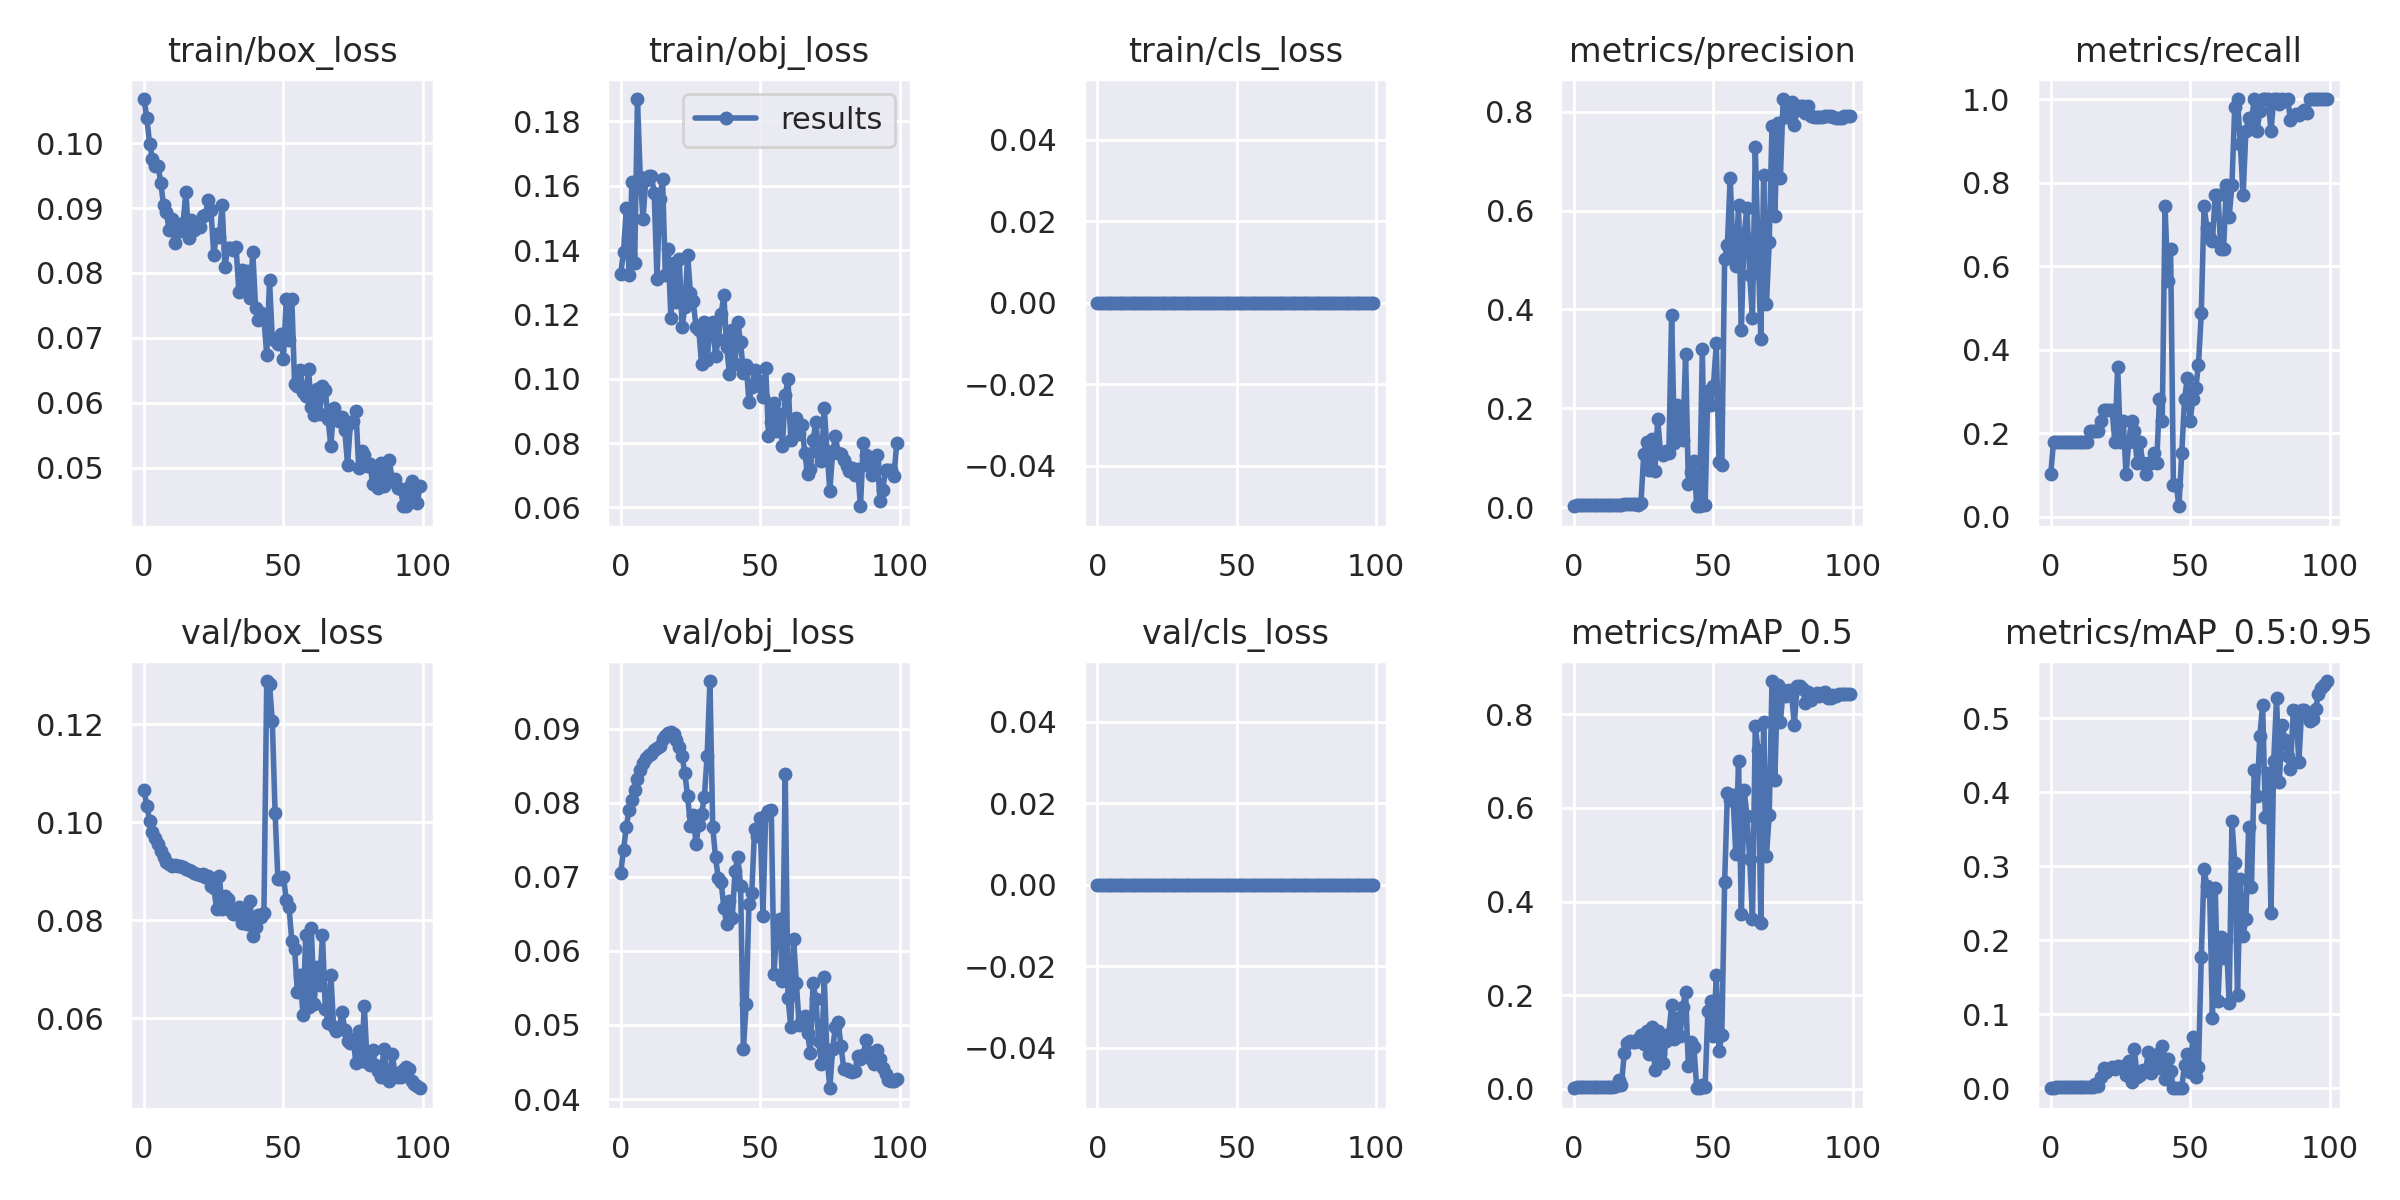

In [12]:
#Visualize Results 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH AUGMENTED TRAINING DATA:


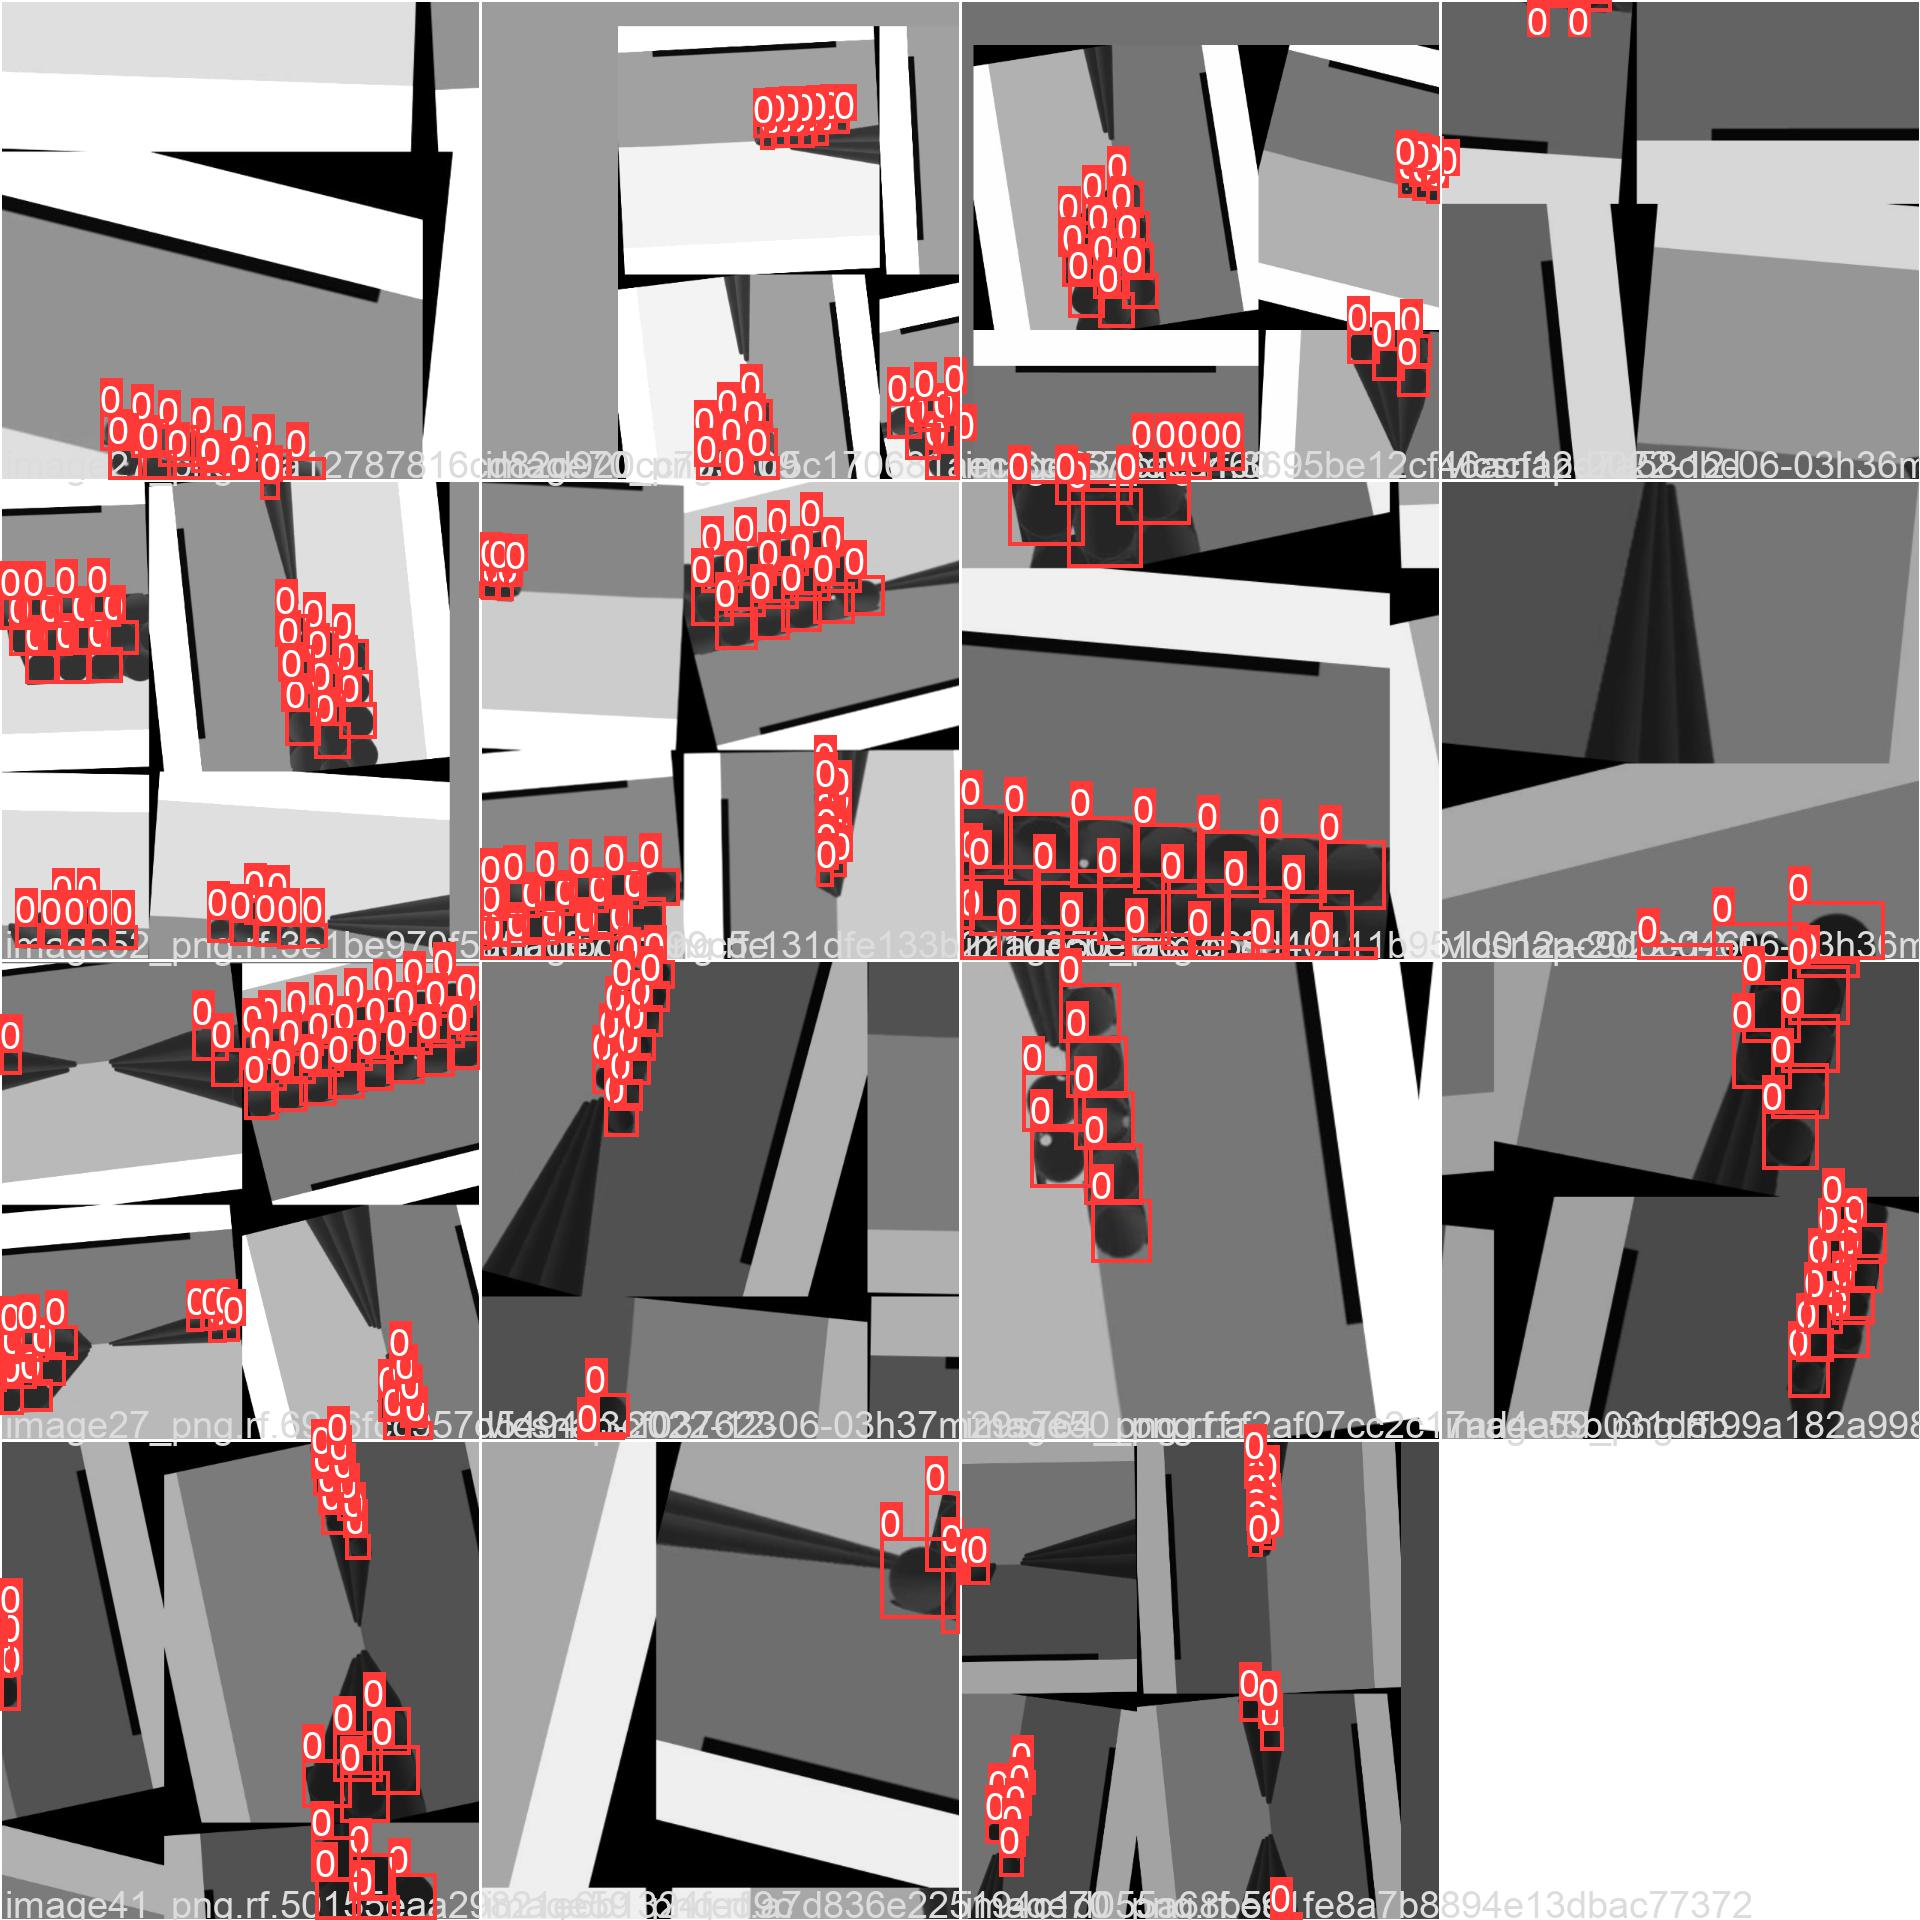

In [13]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch2.jpg', width=900)

In [14]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [15]:
#save best weight we got from training model in drive
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights and video elsewhere for inference on your device elsewhere

In [16]:
#Save best weights in drive
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/drive/MyDrive/od_weights

In [17]:
#Get saved weight from drive to get result on test images
%cd /content/yolov5/
!python /content/yolov5/detect.py --weights /content/drive/MyDrive/od_weights/best.pt --img 640 --conf 0.7 --source /content/yolov5/Pipes-7/test/images

/content/yolov5
detect: weights=['/content/drive/MyDrive/od_weights/best.pt'], source=/content/yolov5/Pipes-7/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
image 1/3 /content/yolov5/Pipes-7/test/images/image26_png.rf.ef1e245d2555382e4296aa943aec84ad.jpg: 640x640 6 Pipes, Done. (0.014s)
image 2/3 /content/yolov5/Pipes-7/test/images/image63_png.rf.f9be88045f62e1420a8b6ac125b38408.jpg: 640x640 12 Pipes, Done. (0.014s)
image 3/3 /content/yolov5/Pipes-7/test/images/

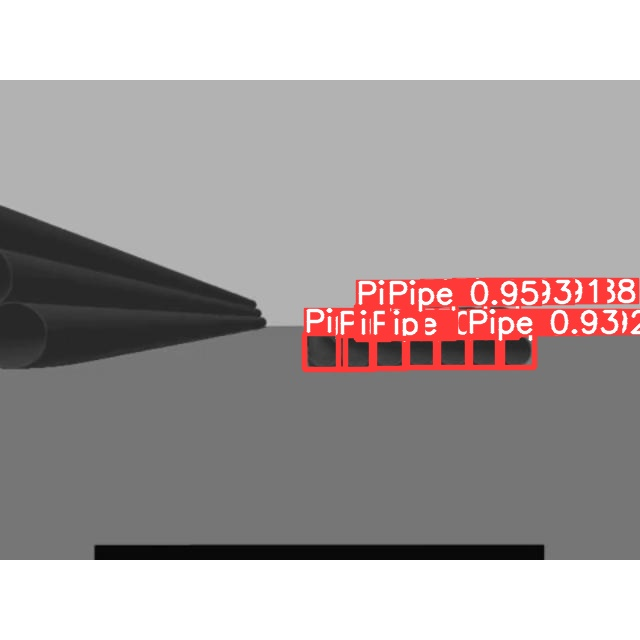

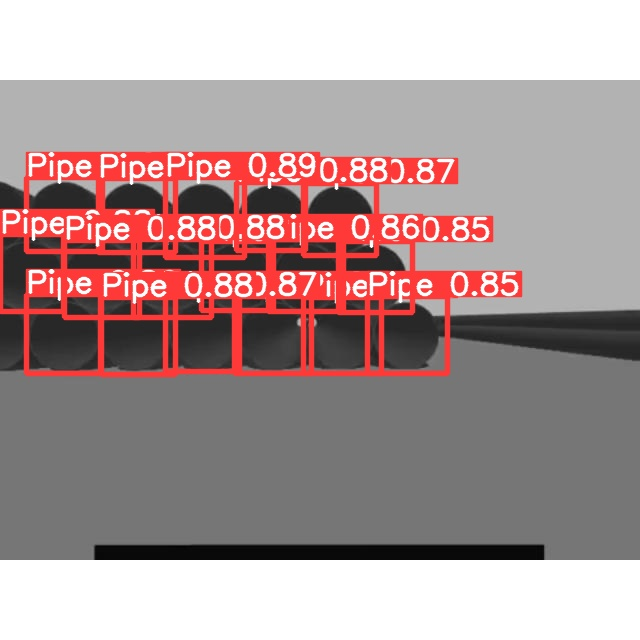

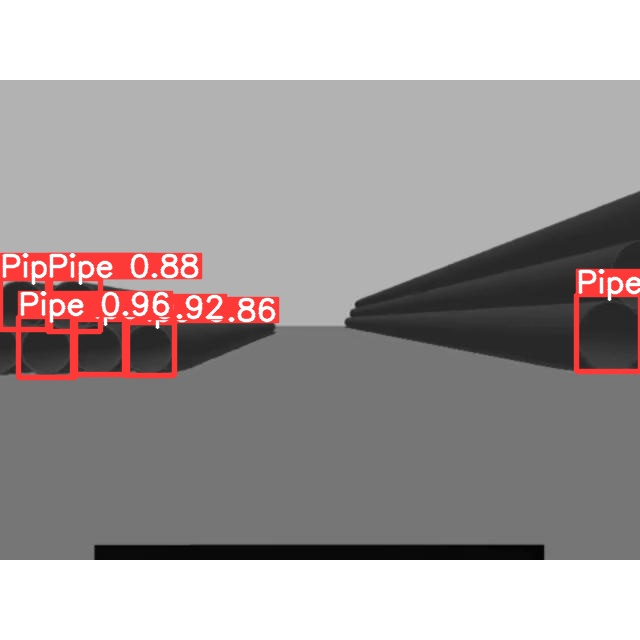

In [18]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming jpg
    display(Image(filename=imageName))
    print("\n")

### Experiment with different parameter like confidance value and make change in detect.py file to get expected result and to keep tracks of number of Pipes of different types in image or video

In [29]:
#Get saved weight from drive to get result on test images
%cd /content/yolov5/
!python /content/yolov5/detect.py --weights /content/drive/MyDrive/od_weights/best.pt --img 640 --conf 0.7 --source /content/yolov5/test_image

/content/yolov5
detect: weights=['/content/drive/MyDrive/od_weights/best.pt'], source=/content/yolov5/test_image, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
image 1/3 /content/yolov5/test_image/image13.png: 480x640 7 Pipes, Done. (0.014s)
image 2/3 /content/yolov5/test_image/image33.png: 480x640 13 Pipes, Done. (0.011s)
image 3/3 /content/yolov5/test_image/image70.png: 480x640 12 Pipes, Done. (0.011s)
Speed: 0.5ms pre-process, 11.9ms inference, 1.1ms NMS per image at sha

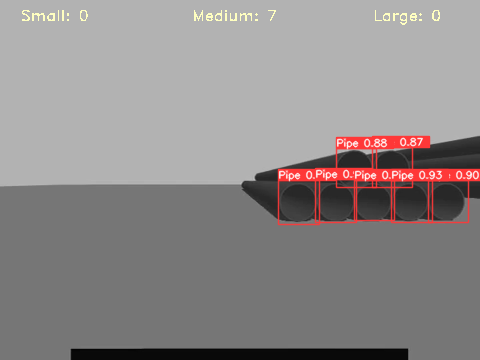

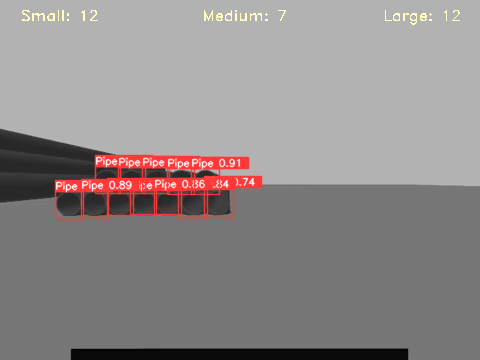

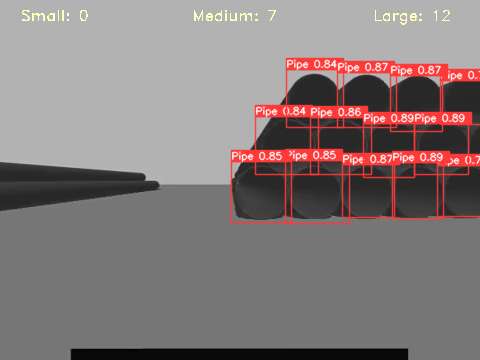

In [30]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.png'): #assuming png
    display(Image(filename=imageName))
    print("\n")

In [31]:
# Get output video from yolov4s model using saved weights and save it in detect folder
%cd /content/yolov5/
!python /content/yolov5/detect.py --weights /content/drive/MyDrive/best.pt --img 640 --conf 0.7 --source /content/drive/MyDrive/ATOM_task/videoplayback.mp4

/content/yolov5
detect: weights=['/content/drive/MyDrive/best.pt'], source=/content/drive/MyDrive/ATOM_task/videoplayback.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
video 1/1 (1/2463) /content/drive/MyDrive/ATOM_task/videoplayback.mp4: 480x640 Done. (0.014s)
video 1/1 (2/2463) /content/drive/MyDrive/ATOM_task/videoplayback.mp4: 480x640 Done. (0.011s)
video 1/1 (3/2463) /content/drive/MyDrive/ATOM_task/videoplayback.mp4: 480x640 Done. (0.011s)
video 1/1 (4/2463) /con

In [36]:
#Save video in drive
%cp /content/yolov5/runs/detect/exp3/videoplayback.mp4 /content/drive/MyDrive

### Download entire folder yolov5 folder locally 

In [37]:
!zip -r /content/yolov5.zip /content/yolov5

updating: content/yolov5/ (stored 0%)
updating: content/yolov5/.pre-commit-config.yaml (deflated 60%)
updating: content/yolov5/tutorial.ipynb (deflated 79%)
updating: content/yolov5/utils/ (stored 0%)
updating: content/yolov5/utils/downloads.py (deflated 65%)
updating: content/yolov5/utils/benchmarks.py (deflated 69%)
updating: content/yolov5/utils/__pycache__/ (stored 0%)
updating: content/yolov5/utils/__pycache__/torch_utils.cpython-38.pyc (deflated 44%)
updating: content/yolov5/utils/__pycache__/callbacks.cpython-38.pyc (deflated 54%)
updating: content/yolov5/utils/__pycache__/dataloaders.cpython-38.pyc (deflated 50%)
updating: content/yolov5/utils/__pycache__/plots.cpython-38.pyc (deflated 45%)
updating: content/yolov5/utils/__pycache__/downloads.cpython-38.pyc (deflated 42%)
updating: content/yolov5/utils/__pycache__/__init__.cpython-38.pyc (deflated 29%)
updating: content/yolov5/utils/__pycache__/loss.cpython-38.pyc (deflated 46%)
updating: content/yolov5/utils/__pycache__/autoba

In [38]:
from google.colab import files
files.download("/content/yolov5.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>